In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Defining Functions

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Query for Disappearing Stars

In [4]:
jdnow = str(Time.now().jd)

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand > 5)
AND (objects.ncand < 20)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ((objects.mag_r28 < objects.mag_r08 < objects.mag_r02)
   OR (objects.mag_g28 < objects.mag_g08 < objects.mag_g02))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < 5

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)
    
print('Query returned ' + str(len(v4)) + ' candidates')

Query returned 39 candidates


### Plotting Light Curves from Alert Packet and ZTF archive 

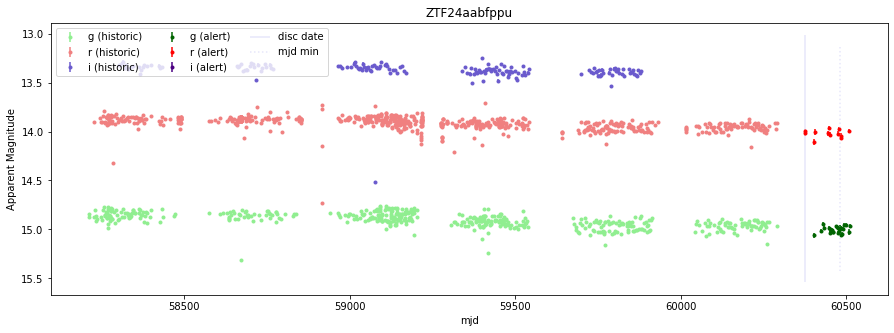

ZTF24aabfppu g-band KS result: KstestResult(statistic=0.7638095238095238, pvalue=8.215650382226158e-15)
ZTF24aabfppu r-band KS result: KstestResult(statistic=0.8519447929736512, pvalue=3.858732222639105e-10)

ZTF24aabfppu g-band Chi Square statistic: 49.26213142917439
ZTF24aabfppu r-band Chi Square statistic: 48.2932694400039



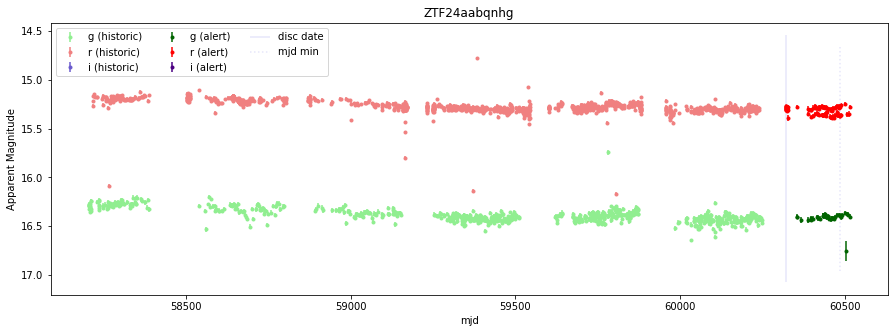

ZTF24aabqnhg g-band KS result: KstestResult(statistic=0.30834495583449556, pvalue=0.0021620334290425314)
ZTF24aabqnhg r-band KS result: KstestResult(statistic=0.49696969696969695, pvalue=6.661338147750939e-16)

ZTF24aabqnhg g-band Chi Square statistic: 11.288205525569207
ZTF24aabqnhg r-band Chi Square statistic: 23.186478605560858



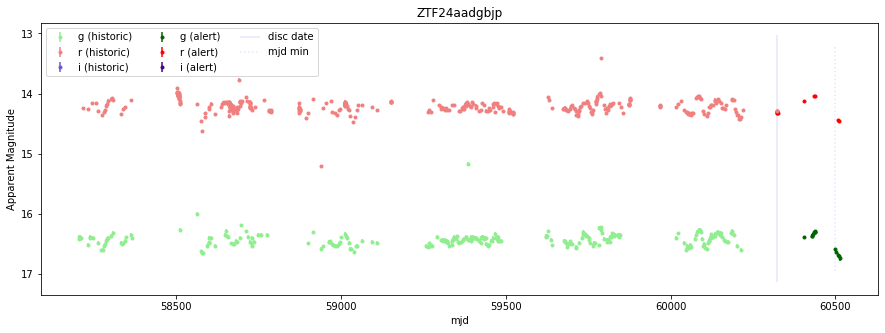

ZTF24aadgbjp g-band KS result: KstestResult(statistic=0.34832506203473945, pvalue=0.07665726106262627)
ZTF24aadgbjp r-band KS result: KstestResult(statistic=0.6001636661211129, pvalue=0.0006570606867936091)

ZTF24aadgbjp g-band Chi Square statistic: 14.902881455134363
ZTF24aadgbjp r-band Chi Square statistic: 27.151478967509753



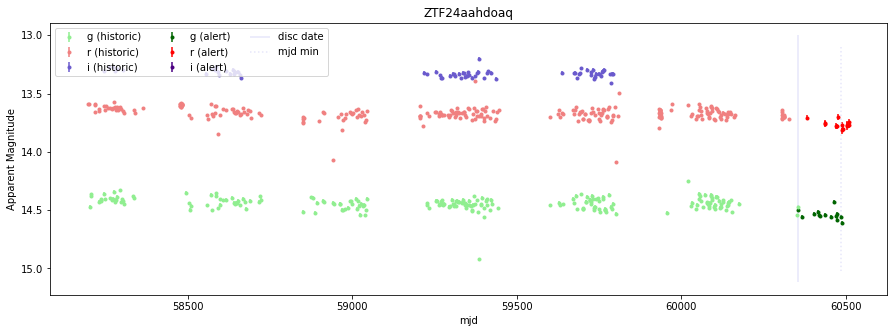

ZTF24aahdoaq g-band KS result: KstestResult(statistic=0.8225806451612904, pvalue=4.619049587262225e-10)
ZTF24aahdoaq r-band KS result: KstestResult(statistic=0.8229166666666666, pvalue=1.4069780895908934e-09)

ZTF24aahdoaq g-band Chi Square statistic: 16.41450009956526
ZTF24aahdoaq r-band Chi Square statistic: 43.46058893691134



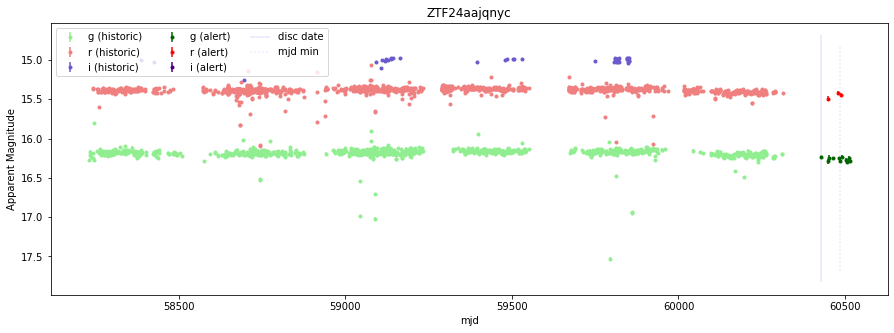

ZTF24aajqnyc g-band KS result: KstestResult(statistic=0.9486931268151017, pvalue=3.852473895449293e-14)
ZTF24aajqnyc r-band KS result: KstestResult(statistic=0.9471882640586797, pvalue=0.00031032640705519476)

ZTF24aajqnyc g-band Chi Square statistic: 23.91406146300692
ZTF24aajqnyc r-band Chi Square statistic: 16.78843872447408



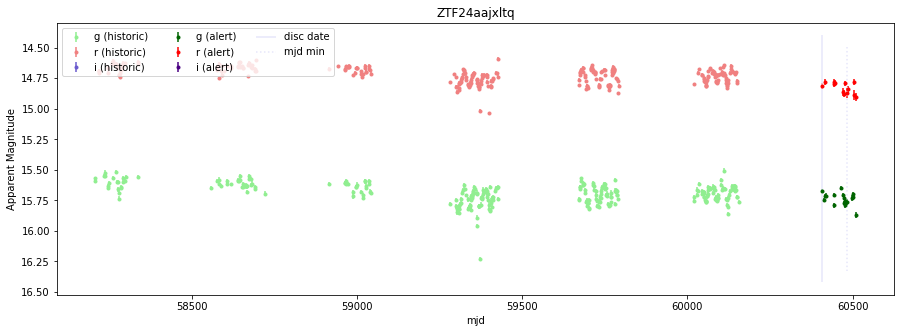

ZTF24aajxltq g-band KS result: KstestResult(statistic=0.4492543496271748, pvalue=0.001811540863375205)
ZTF24aajxltq r-band KS result: KstestResult(statistic=0.7730496453900709, pvalue=3.316405183806381e-08)

ZTF24aajxltq g-band Chi Square statistic: 24.237947025267935
ZTF24aajxltq r-band Chi Square statistic: 32.79413289129564



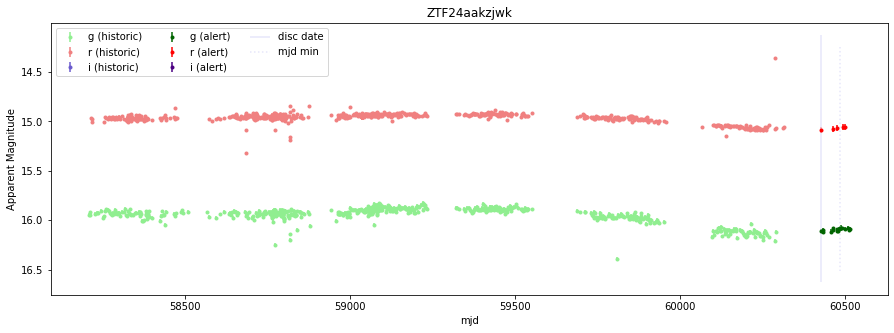

ZTF24aakzjwk g-band KS result: KstestResult(statistic=0.9066265060240963, pvalue=6.235054003760539e-18)
ZTF24aakzjwk r-band KS result: KstestResult(statistic=0.9580973952434881, pvalue=3.7394307450533404e-07)

ZTF24aakzjwk g-band Chi Square statistic: 20.320347053545813
ZTF24aakzjwk r-band Chi Square statistic: 16.856857751890747



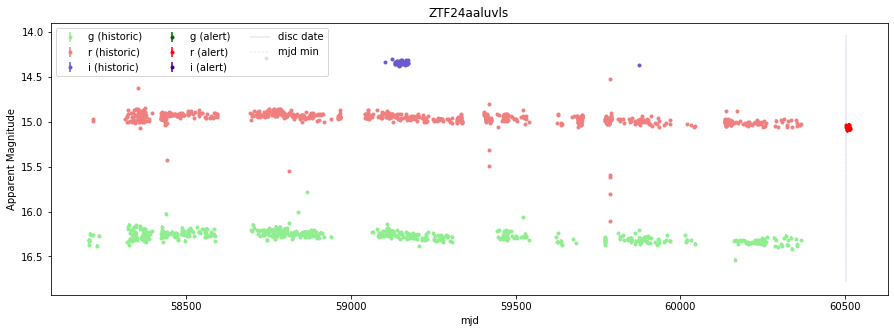

ZTF24aaluvls r-band KS result: KstestResult(statistic=0.9645390070921985, pvalue=2.220446049250313e-16)

ZTF24aaluvls r-band Chi Square statistic: 46.42452638990714



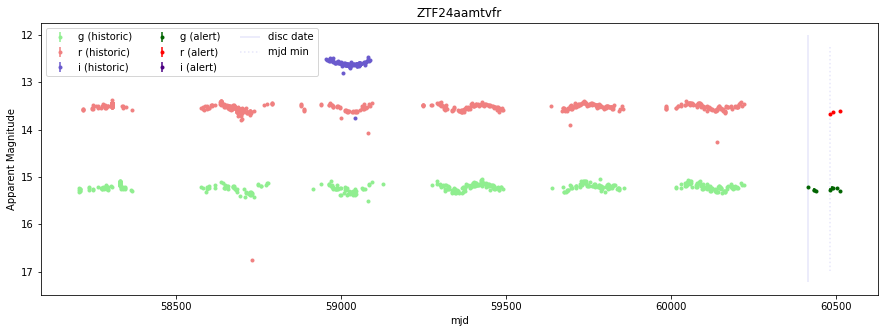

ZTF24aamtvfr g-band KS result: KstestResult(statistic=0.5711645101663586, pvalue=0.0029220234270393997)
ZTF24aamtvfr r-band KS result: KstestResult(statistic=0.9493293591654247, pvalue=0.0002825126568438696)

ZTF24aamtvfr g-band Chi Square statistic: 15.45175504566577
ZTF24aamtvfr r-band Chi Square statistic: 32.362520066632996



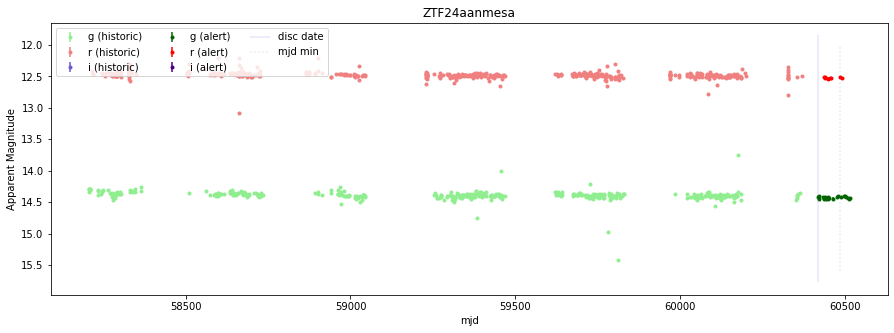

ZTF24aanmesa g-band KS result: KstestResult(statistic=0.6512820512820513, pvalue=1.9191207512037067e-09)
ZTF24aanmesa r-band KS result: KstestResult(statistic=0.9119226638023631, pvalue=1.0656124316277271e-08)

ZTF24aanmesa g-band Chi Square statistic: 28.477647446135762
ZTF24aanmesa r-band Chi Square statistic: 15.087716938054413



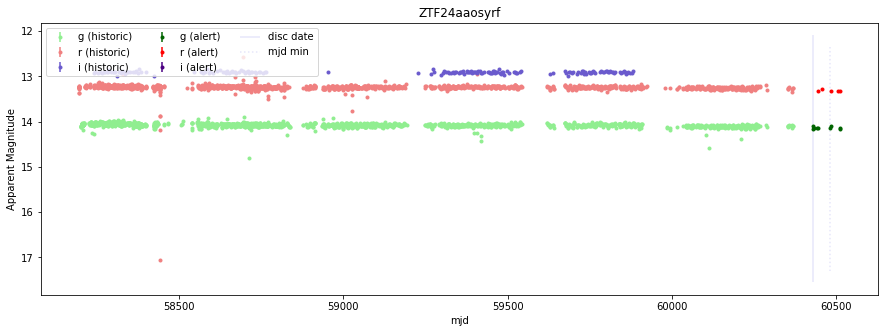

ZTF24aaosyrf g-band KS result: KstestResult(statistic=0.822808671065033, pvalue=3.863275518378728e-07)
ZTF24aaosyrf r-band KS result: KstestResult(statistic=0.9715481171548117, pvalue=4.593859603829742e-08)

ZTF24aaosyrf g-band Chi Square statistic: 13.812344273064856
ZTF24aaosyrf r-band Chi Square statistic: 38.75871820641581



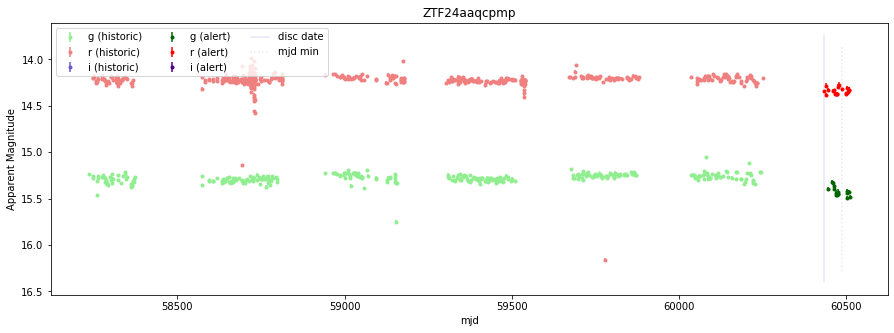

ZTF24aaqcpmp g-band KS result: KstestResult(statistic=0.8869047619047619, pvalue=2.275957200481571e-14)
ZTF24aaqcpmp r-band KS result: KstestResult(statistic=0.9728783902012248, pvalue=7.771561172376096e-16)

ZTF24aaqcpmp g-band Chi Square statistic: 14.799352481762586
ZTF24aaqcpmp r-band Chi Square statistic: 26.01081291949652



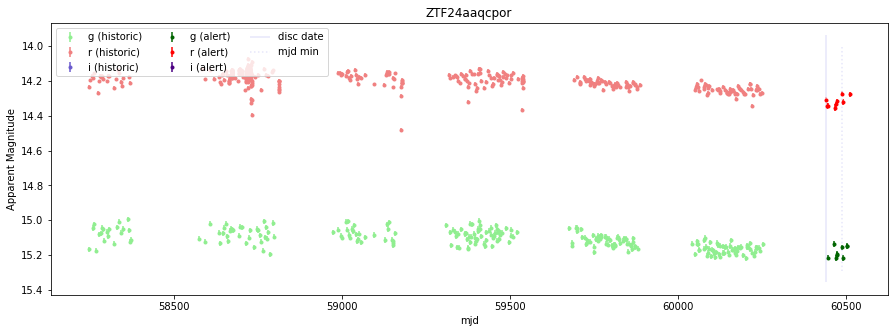

ZTF24aaqcpor g-band KS result: KstestResult(statistic=0.6875, pvalue=0.00013797234430357186)
ZTF24aaqcpor r-band KS result: KstestResult(statistic=0.9713774597495528, pvalue=2.567945855957987e-13)

ZTF24aaqcpor g-band Chi Square statistic: 11.74378174624929
ZTF24aaqcpor r-band Chi Square statistic: 18.32696543924238



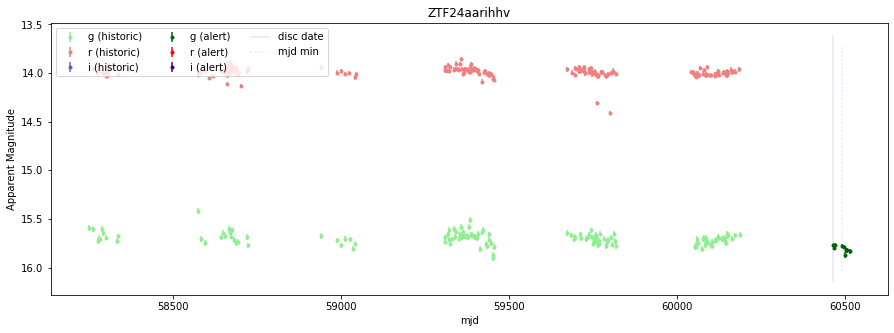

ZTF24aarihhv g-band KS result: KstestResult(statistic=0.8625954198473282, pvalue=2.1490696966441902e-07)

ZTF24aarihhv g-band Chi Square statistic: 4.859184696352617



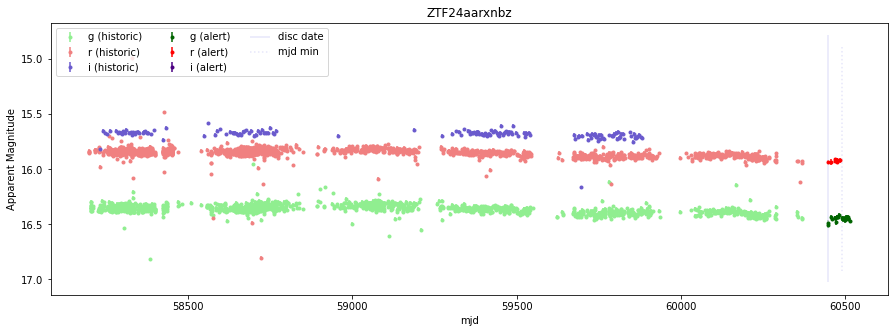

ZTF24aarxnbz g-band KS result: KstestResult(statistic=0.9433638443935927, pvalue=1.1102230246251565e-16)
ZTF24aarxnbz r-band KS result: KstestResult(statistic=0.9749518304431599, pvalue=5.192513086171857e-13)

ZTF24aarxnbz g-band Chi Square statistic: 8.091079962039629
ZTF24aarxnbz r-band Chi Square statistic: 12.391566830700189



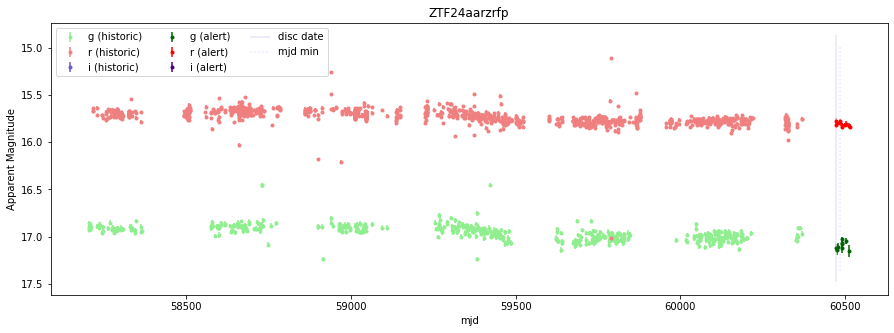

ZTF24aarzrfp g-band KS result: KstestResult(statistic=0.8194130925507901, pvalue=6.524108184802202e-07)
ZTF24aarzrfp r-band KS result: KstestResult(statistic=0.8467952058363731, pvalue=2.6562079202818722e-09)

ZTF24aarzrfp g-band Chi Square statistic: 11.237973683010468
ZTF24aarzrfp r-band Chi Square statistic: 19.3479258976961



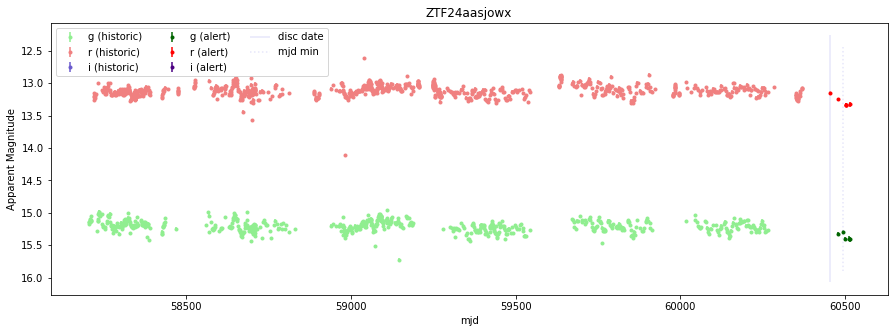

ZTF24aasjowx g-band KS result: KstestResult(statistic=0.8814814814814815, pvalue=5.4949206534149475e-05)
ZTF24aasjowx r-band KS result: KstestResult(statistic=0.7986666666666666, pvalue=0.00014214522741051727)

ZTF24aasjowx g-band Chi Square statistic: 20.6327205536802
ZTF24aasjowx r-band Chi Square statistic: 17.253154533217597



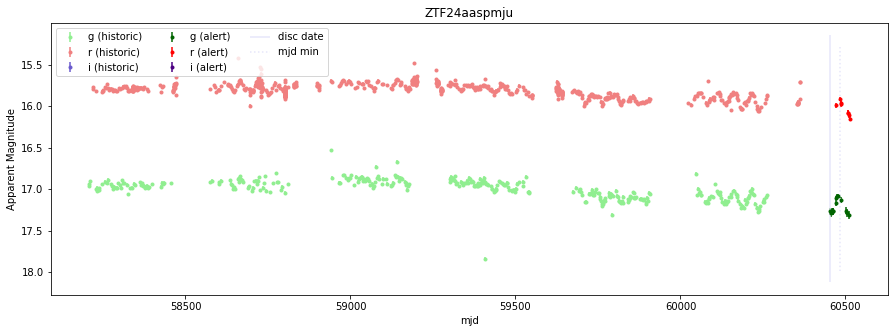

ZTF24aaspmju g-band KS result: KstestResult(statistic=0.7642045454545454, pvalue=4.33523262843849e-08)
ZTF24aaspmju r-band KS result: KstestResult(statistic=0.9196865817825661, pvalue=5.1104902532017604e-09)

ZTF24aaspmju g-band Chi Square statistic: 40.631562390319914
ZTF24aaspmju r-band Chi Square statistic: 27.70596150471772



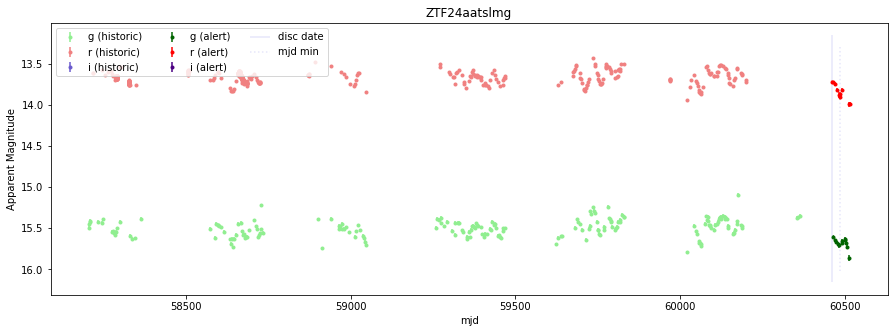

ZTF24aatslmg g-band KS result: KstestResult(statistic=0.8452380952380952, pvalue=2.3814094030072397e-09)
ZTF24aatslmg r-band KS result: KstestResult(statistic=0.8225108225108225, pvalue=9.161824665593343e-08)

ZTF24aatslmg g-band Chi Square statistic: 29.656702228862653
ZTF24aatslmg r-band Chi Square statistic: 31.739746169899302



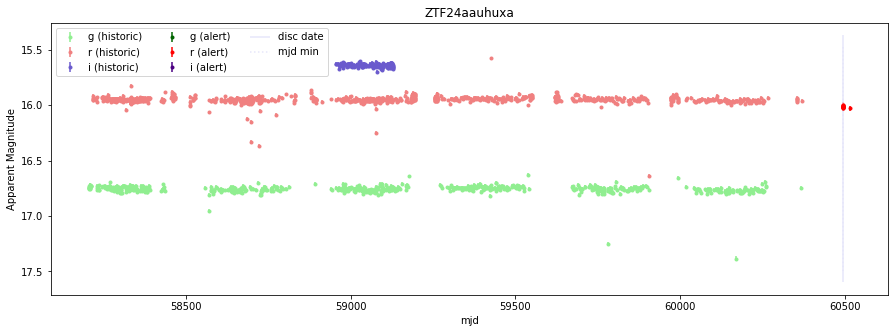

ZTF24aauhuxa r-band KS result: KstestResult(statistic=0.986351228389445, pvalue=1.1408967996413238e-24)

ZTF24aauhuxa r-band Chi Square statistic: 5.334585152351672



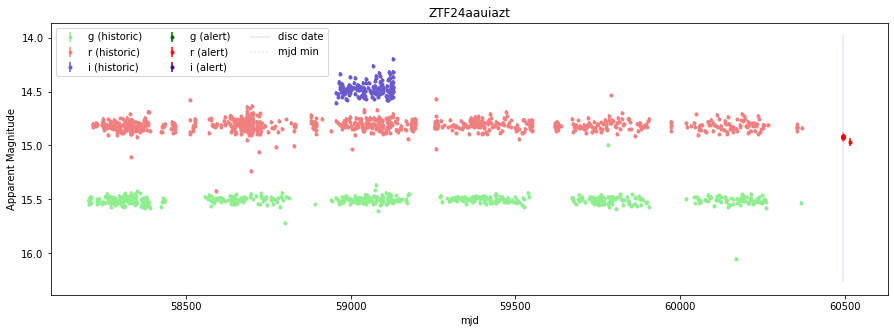

ZTF24aauiazt r-band KS result: KstestResult(statistic=0.9893711248892826, pvalue=0.0)

ZTF24aauiazt r-band Chi Square statistic: 9.564346473487124



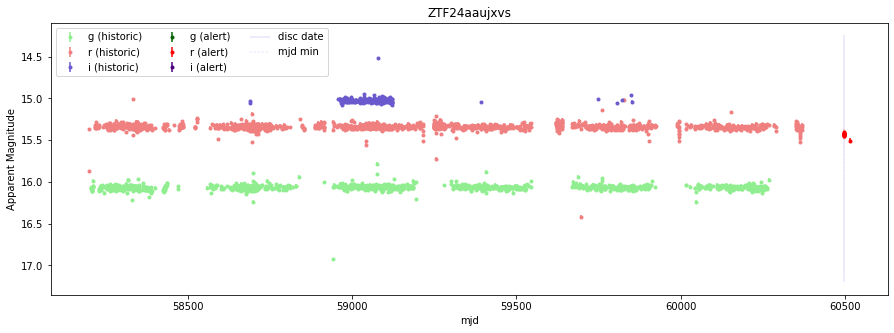

ZTF24aaujxvs r-band KS result: KstestResult(statistic=0.9864068871771635, pvalue=1.4706011372169932e-26)

ZTF24aaujxvs r-band Chi Square statistic: 5.546358857991253



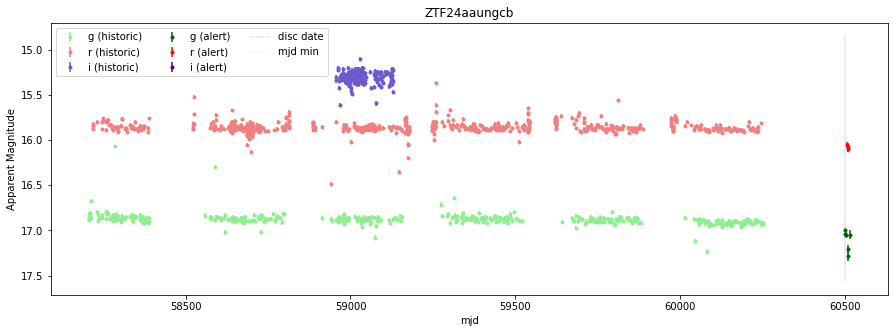

ZTF24aaungcb g-band KS result: KstestResult(statistic=0.9878640776699029, pvalue=1.293007922953393e-10)
ZTF24aaungcb r-band KS result: KstestResult(statistic=0.9941860465116279, pvalue=1.049175305634087e-06)

ZTF24aaungcb g-band Chi Square statistic: 9.509094050659458
ZTF24aaungcb r-band Chi Square statistic: 8.546633007318931



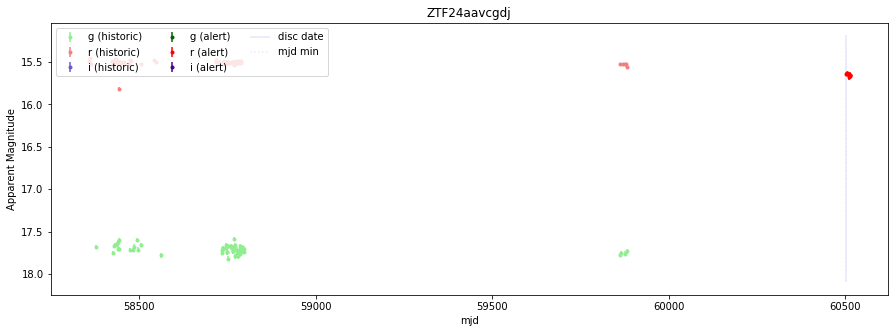

ZTF24aavcgdj r-band KS result: KstestResult(statistic=0.9875, pvalue=3.845812557301542e-12)

ZTF24aavcgdj r-band Chi Square statistic: 8.681724529985946



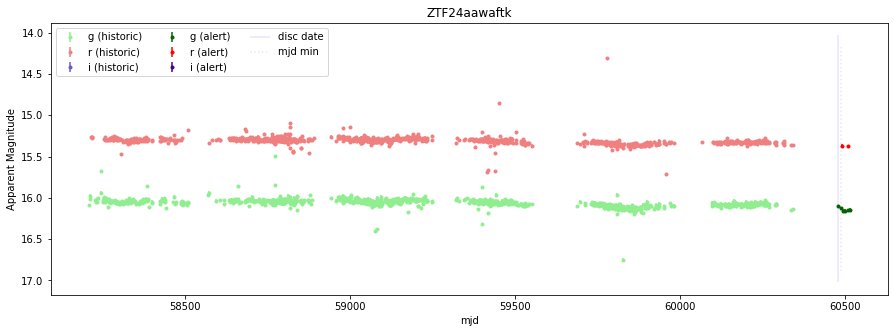

ZTF24aawaftk g-band KS result: KstestResult(statistic=0.8982142857142857, pvalue=2.6154501794328766e-06)
ZTF24aawaftk r-band KS result: KstestResult(statistic=0.9803784162578837, pvalue=0.0008526853708592519)

ZTF24aawaftk g-band Chi Square statistic: 9.706217462002606
ZTF24aawaftk r-band Chi Square statistic: 13.75127824674328



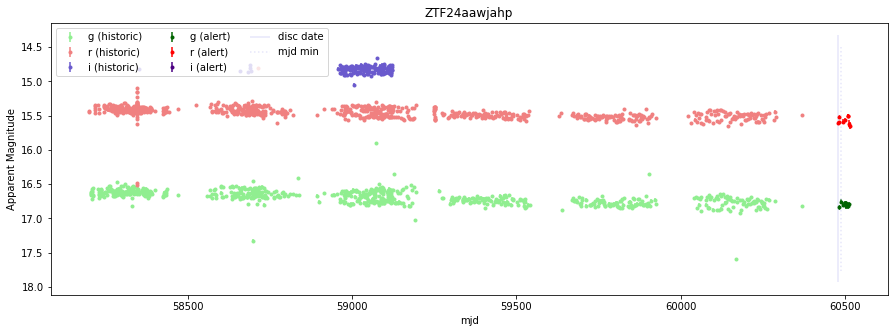

ZTF24aawjahp g-band KS result: KstestResult(statistic=0.7930591259640103, pvalue=1.8728807124057667e-06)
ZTF24aawjahp r-band KS result: KstestResult(statistic=0.8143261074458058, pvalue=6.502212334114077e-07)

ZTF24aawjahp g-band Chi Square statistic: 29.822809423646675
ZTF24aawjahp r-band Chi Square statistic: 27.93361666602737



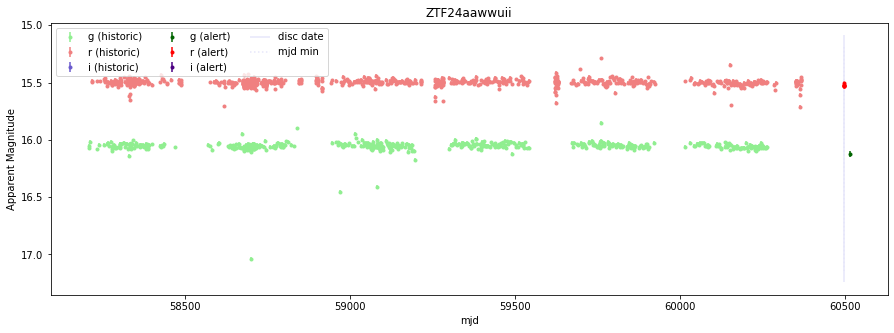

ZTF24aawwuii g-band KS result: KstestResult(statistic=0.9893238434163701, pvalue=0.0248667850799289)
ZTF24aawwuii r-band KS result: KstestResult(statistic=0.7317643820533994, pvalue=0.0008742200876674655)

ZTF24aawwuii g-band Chi Square statistic: 9.960266234667307
ZTF24aawwuii r-band Chi Square statistic: 4.070896996568188

12 stars in trash
27 candidates remain


In [5]:
Dips= L.objects([row['objectId'] for row in v4])
lc = {}
candidates = []
trash = []

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
    
    # Defining arrays of ZTF historic magnitudes for each filter
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_isamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_ierr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_imjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors
    gmag = []
    rmag = []
    imag = []
    
    gerr = []
    rerr = []
    ierr = []
    
    gmjd = []
    rmjd = []
    imjd = []
    
    for i in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in i:
            app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos']) # calculating apparent magnitude 
            app_err = app_mag_err_prop(i['magnr'], i['magpsf'], i['isdiffpos'], i['sigmagnr'], i['sigmapsf']) # propagating error
            
            # appending magnitudes and errors in each filter to their respective lists
            if i['fid']== 1:
                gmag.append(app_mag)
                gerr.append(app_err)
                gmjd.append(i['mjd'])
            if i['fid']== 2:
                rmag.append(app_mag)
                rerr.append(app_err)
                rmjd.append(i['mjd'])
            if i['fid']== 3:
                imag.append(app_mag)
                ierr.append(app_err)
                imjd.append(i['mjd'])
    
    
    # Converting lists of alert packet magnitudes to arrays 
    alert_gsamp = np.array(gmag)
    alert_rsamp = np.array(rmag)
    alert_isamp = np.array(imag)
    
    # Performing K-S test with 95% confidence intervals for each filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
        KS_g = st.ks_2samp(alert_gsamp, ztf_gsamp)
        #D_crit_g = 1.36*((1/len(alert_gsamp))+(1/len(ztf_gsamp)))
            
    if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
        KS_r = st.ks_2samp(alert_rsamp, ztf_rsamp)
        #D_crit_r = 1.36*((1/len(alert_rsamp))+(1/len(ztf_rsamp)))

    if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
        KS_i = st.ks_2samp(alert_isamp, ztf_isamp)
        #D_crit_i = 1.36*((1/len(alert_isamp))+(1/len(ztf_isamp)))
   
    
    # Calculating Chi Square statistics for each filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
        chisq_g = np.sum((((ztf_gsamp - np.median(ztf_gsamp)) / ztf_gerr)**2 ) / float(len(ztf_gsamp)))
        #df_g = len(ztf_gsamp) - 1
        #crit_g = st.chi2.ppf(0.95, df_g)
        
    if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
        chisq_r = np.sum((((ztf_rsamp - np.median(ztf_rsamp)) / ztf_rerr)**2 ) / float(len(ztf_rsamp)))
        #df_r = len(ztf_rsamp) - 1
        #crit_r = st.chi2.ppf(0.95, df_r)
        
    if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
        chisq_i = np.sum((((ztf_isamp - np.median(ztf_isamp)) / ztf_ierr)**2 ) / float(len(ztf_isamp)))
        #df_i = len(ztf_isamp) - 1
        #crit_i = st.chi2.ppf(0.95, df_i)
    
    # Imposing conditions that K-S test p-value is < 0.05 (95% confidence interval) and Chi square statistic is < 50
    if ((len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_g.pvalue < 0.05) and 
        (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or KS_r.pvalue < 0.05) and 
        (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_i.pvalue < 0.05) and 
        (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or chisq_g < 50) and 
        (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or chisq_r < 50) and 
        (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or chisq_i < 50)):
        
        candidates.append(obj['objectId'])
        
        # Plotting
        plt.figure(figsize = (15, 5))
        plt.subplot(111)

        ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
        ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
        ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

        gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
        rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
        ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

        mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lavender', linestyles=':', label='mjd min')  
        disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
        plt.gca().invert_yaxis()
        plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
        plt.ylabel('Apparent Magnitude')
        plt.xlabel('mjd')
        plt.title(obj['objectId'])
        plt.show()

        # Printing K-S test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band KS result: '+ str(KS_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band KS result: '+ str(KS_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band KS result: '+ str(KS_i))

        print()

        # Printing Chi Square test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
            #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
            #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
            #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

        print() 
        
    else:
        
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or KS_g.pvalue < 0.05):
#             print('failed g K-S test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or KS_r.pvalue < 0.05):
#             print('failed r K-S test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_i.pvalue < 0.05):
#             print('failed i K-S test')
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or chisq_g < 50):
#             print('failed g Chi square test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or chisq_r < 50):
#             print('failed r Chi square test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or chisq_i < 50):
#             print('failed i Chi square test')
        
        trash.append(obj['objectId'])

#         # Plotting
#         plt.figure(figsize = (15, 5))
#         plt.subplot(111)

#         ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
#         ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
#         ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

#         gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
#         rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
#         ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

#         mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
#         disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
#         plt.gca().invert_yaxis()
#         plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
#         plt.ylabel('Apparent Magnitude')
#         plt.xlabel('mjd')
#         plt.title(obj['objectId'])
#         plt.show()

#         # Printing K-S test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band KS result: '+ str(KS_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band KS result: '+ str(KS_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band KS result: '+ str(KS_i))

#         print()

#         # Printing Chi Square test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
#             #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
#             #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
#             #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

#         print() 
   
print(str(len(trash)) + ' stars in trash')
print(str(len(candidates)) + ' candidates remain') 